# Import packages and data

In [1088]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from category_encoders import OrdinalEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score

In [931]:
POLICY_DATA = '../data/datastorm_policy_data.csv'
AGENT_DATA = '../data/datastorm_agent_data.csv'
TEST_DATA = '../data/testset.csv'

In [938]:
df_pred = pd.read_csv(TEST_DATA, index_col='map_client_cd')

In [991]:
df_agent = pd.read_csv(AGENT_DATA)

In [992]:
df = pd.read_csv(POLICY_DATA, parse_dates=['next_due_dt', 'termination_dt', 
                                           'main_holder_dob', 'spouse_dob', 
                                           'child1_dob', 'child2_dob', 
                                           'child3_dob', 'child4_dob', 
                                           'child5_dob', 
                                           'run_date', 'commencement_dt'])

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [993]:
df = df.merge(df_agent, on='agent_code', how='left')

In [994]:
df = df.drop(columns=['main_holder_occupation_cd', 'product_code'])

# Data Cleaning

## Removing duplicate columns 

In [995]:
df = df.drop_duplicates(subset=['policy_code', 'client_code', 'policy_snapshot_as_on'], keep='first')

## Remove policy snapshot with very small interval

In [996]:
df = df[df.policy_snapshot_as_on != 20190831]

In [997]:
df.head()

,policy_term,policy_payment_mode,policy_status,commencement_dt,next_due_dt,termination_dt,termination_reason,main_holder_gender,main_holder_dob,main_holder_entry_age,...,date_joined,status,substatus,termination_date,city_name,cluster_code,supervisor_code,zone_code,region_code,designation
0,20,M,INFORCE,2011-08-21,2019-02-21,NaT,NaN,M,1983-10-01,28,...,2018/02/27,TERMINATED,AUTOTERMINATED,2018/10/31,Colombo 03,LA01002,AG107931,ZONE105,RA262,Advisor
1,15,M,INFORCE,2006-07-14,2019-09-14,NaT,NaN,F,1958-01-01,48,...,1998/10/02,INFORCED,ACTIVE,NaN,Moratuwa,LA01001,AG100875,ZONE110,RA248,Advisor
2,20,Y,INFORCE,2018-12-28,2019-12-28,NaT,NaN,M,1967-11-01,51,...,2014/06/25,INFORCED,ACTIVE,NaN,Batticaloa,LA01004,AG101697,ZONE107,RA231,Team Leader
3,15,Q,INFORCE,2018-11-06,2020-02-06,NaT,NaN,M,1989-10-01,29,...,2014/03/20,INFORCED,ACTIVE,NaN,Ratnapura,LA01002,AG104896,ZONE114,RA269,Advisor
4,15,M,LAPSED,2012-04-28,2015-06-28,NaT,OTHERS,M,1988-05-01,24,...,2001/05/24,INFORCED,ACTIVE,NaN,Wadduwa,LA01002,AG104545,ZONE114,RA257,Advisor


# Create Labels

In [998]:
def create_labels(df, train_snap_date, label_last_date):
    snap_df = df[(df.policy_snapshot_as_on == train_snap_date) 
                    & (df.policy_status == 'INFORCE')][['client_code', 
                                                        'policy_code', 
                                                        'product_name']]
    cust_df = df[(df.policy_snapshot_as_on == train_snap_date)][[
        'client_code']].drop_duplicates().set_index('client_code')

    label_df = df[(df.policy_snapshot_as_on > train_snap_date) 
                     & (df.policy_snapshot_as_on <= label_last_date) 
                     & (df.policy_status == 'INFORCE')][['client_code', 
                                                         'product_name', 
                                                         'policy_code', 
                                                         'policy_snapshot_as_on']]
    
    join_df = label_df.merge(snap_df[['policy_code', 'client_code']], 
                             on=['policy_code', 'client_code'], how='left', 
                             indicator=True)
    join_df['is_prev'] = join_df._merge.map({'left_only':0, 'both':1}).astype(int)
    
    #customers who can be c
    cross_sell_eligible = join_df.groupby(['client_code', 
                                           'policy_snapshot_as_on']).is_prev.sum()
    
    cross_sell_eligible.name = 'cross_sell_eligible'
    cross_sell_eligible = cross_sell_eligible[cross_sell_eligible > 0].reset_index()
    
    joined_cs_eligible = join_df.merge(cross_sell_eligible, 
                                       on=['client_code', 
                                           'policy_snapshot_as_on'], 
                                       how='left').dropna()
    
    labels = joined_cs_eligible[joined_cs_eligible.is_prev == 0][[
        'client_code', 'product_name']].drop_duplicates()
    labels['value'] = 1
    pivot_labels = labels.pivot_table(values='value', index='client_code', 
                                      aggfunc='sum',
                                      columns='product_name').fillna(0).astype(int)

    return cust_df.merge(pivot_labels, on='client_code', how='left').fillna(0)


# Create Client Dataset

In [1021]:
def client_dataset(df, snap_date):
    df_snap = df[(df.policy_snapshot_as_on == snap_date)]
    
    df_snap.status = df_snap.status + '_AGENT'
    
    customer_specific_features = ['main_holder_gender', 'main_holder_dob',
                               'main_holder_smoker_flag', 'spouse_gender',
                               'spouse_dob', 'spouse_smoker_flag',
                               'child1_dob', 'child1_gender', 'child2_dob',
                               'child2_gender', 'child3_dob', 'child3_gender', 
                               'child4_dob', 'child4_gender', 'child5_dob', 
                               'child5_gender', 'main_holder_occupation', 
                               'client_code']
    
    df_cust = df_snap[customer_specific_features]

    dob_feat = ['main_holder_dob', 'spouse_dob', 'child1_dob', 'child2_dob',
           'child3_dob', 'child4_dob', 'child5_dob']

    age_feat = []
    for col in dob_feat:
        new_col = col[:-4] + '_age'
        df_cust[new_col] = pd.to_datetime(
            snap_date, format='%Y%m%d').year - df_cust[col].dt.year
        df_cust = df_cust.drop(columns=col)
        age_feat.append(new_col)

    df_cust_numeric = df_cust.groupby('client_code')[age_feat].median()

    df_cust_cat = df_cust.select_dtypes('object').groupby('client_code').first()

    df_cust_fin = df_cust_cat.join(df_cust_numeric)
    
    pivot_cols = ['policy_payment_mode', 'policy_status', 'payment_method', 
                  'status', 'gender']
    
    for col in pivot_cols:
        df_filt = df_snap[['client_code'] + [col]].copy()
        df_filt['value'] = 1
        df_pivot = df_filt.pivot_table(values='value', 
                                       index='client_code', aggfunc='sum', 
                                       columns=col).fillna(0).astype(int)
        df_cust_fin =df_cust_fin.join(
            df_pivot.divide(df_pivot.sum(axis=1), axis=0), how='left')
    
    #policy age
    df_policy_age = df_snap[['client_code', 'policy_snapshot_as_on', 'commencement_dt']]
    
    df_policy_age['policy_age'] = pd.cut(
        ((pd.to_datetime(df_snap.policy_snapshot_as_on, format='%Y%m%d') - df_snap.commencement_dt).dt.days/365),
        bins=[-5,1,5,10,100], labels=['policy_age_1_yr', 'policy_age_5_yr', 'policy_age_10_yr', 'policy_age_40_yr'])
    df_policy_age = df_policy_age.drop(columns=['policy_snapshot_as_on', 'commencement_dt'])
    print(df_policy_age.count())
    df_policy_age['value'] = 1
    df_pivot = df_policy_age.pivot_table(values='value', 
                                           index='client_code', aggfunc='sum', 
                                       columns='policy_age').fillna(0).astype(int)
    df_cust_fin = df_cust_fin.join(
        df_pivot.divide(df_pivot.sum(axis=1), axis=0), how='left')
    
    #next due date
    df_next_due = df_snap[['client_code', 'policy_snapshot_as_on', 'next_due_dt']]
    df_next_due['next_due_age'] = pd.cut(((pd.to_datetime(
        df_snap.policy_snapshot_as_on, format='%Y%m%d') - df_snap.next_due_dt).dt.days/365), 
                                         bins=[-100,-1,-0.2, 0, 0.2, 1, 100], 
                                         labels=['next_due_min_1_yr', 
                                                 'next_due_min_0.2_yr', 
                                                 'next_due_0_yr', 
                                                 'next_due_0.2_yr', 
                                                 'next_due_1_yr', 
                                                 'next_due_100_yr'])

    df_next_due = df_next_due.drop(columns=['policy_snapshot_as_on', 'next_due_dt'])
    df_next_due['value'] = 1
    df_pivot = df_next_due.pivot_table(values='value', 
                                           index='client_code', aggfunc='sum', 
                                           columns='next_due_age').fillna(0).astype(int)
    df_cust_fin = df_cust_fin.join(
        df_pivot.divide(df_pivot.sum(axis=1), axis=0), how='left')
    
    ## Rider information
    rider_sum_cols = ['rider1_sum_assuared', 'rider2_sum_assuared', 
                  'rider3_sum_assuared', 'rider4_sum_assuared', 
                  'rider5_sum_assuared', 'rider6_sum_assuared',
                  'rider7_sum_assuared', 'rider8_sum_assuared', 
                  'rider9_sum_assuared', 'rider10_sum_assuared']

    rider_prem_cols = ['rider1_prem', 'rider2_prem',
           'rider3_prem', 'rider4_prem', 'rider5_prem',
           'rider6_prem', 'rider7_prem', 'rider8_prem',
           'rider9_prem', 'rider10_prem']

    df_rider = df_snap[rider_sum_cols + rider_prem_cols + ['client_code']].copy()

    df_rider['rider_count'] = (df_rider[rider_prem_cols] > 0).sum(axis=1)

    df_rider['rider_prem'] = df_rider[rider_prem_cols].sum(axis=1)

    df_rider['rider_sum_assured'] = df_rider[rider_sum_cols].sum(axis=1)

    df_cust_fin = df_cust_fin.join(
        df_rider.groupby('client_code')['rider_count', 
                                        'rider_prem', 'rider_sum_assured'
                                       ].sum(), how='left')
    
    #Premium information
    df_prem = df_snap[['client_code', 'premium_value', 'total_sum_assuared', 
                       'policy_payment_mode']].copy()
    df_prem['monthly_premium'] = (df_prem.premium_value / 
                                  df_prem.policy_payment_mode.map({'M':1, 
                                                                   'Y':12, 
                                                                   'Q':3, 
                                                                   'H':6, 
                                                                   'S':float('inf')}))
    df_prem = df_prem.drop(columns='policy_payment_mode')
    df_cust_fin = df_cust_fin.join(df_prem.groupby('client_code').sum(), 
                                   how='left')

    return df_cust_fin

In [ ]:
df

In [800]:
df_ag = df_snap[['client_code', 'agent_code', 'status']]

In [801]:
df_ag

,client_code,agent_code,status
8,C107145,AG107526,INFORCED
50,C120466,AG108311,TERMINATED
67,C101690,AG100156,TERMINATED
105,C115813,AG106839,TERMINATED
120,C116685,AG102962,INFORCED
...,...,...,...
631399,C110790,AG101126,INFORCED
631404,C117934,AG106614,INFORCED
631408,C120592,AG108604,INFORCED
631411,C111599,AG104344,INFORCED


In [754]:
df_agent.groupby('client_code').agent

,client_code,agent_code
8,C107145,AG107526
50,C120466,AG108311
67,C101690,AG100156
105,C115813,AG106839
120,C116685,AG102962
...,...,...
631399,C110790,AG101126
631404,C117934,AG106614
631408,C120592,AG108604
631411,C111599,AG104344


In [826]:
df.designation.unique()

array(['Advisor', 'Team Leader', 'Regional Manager',
       'Trainee Regional Sales Manager', 'Zonal Manager'], dtype=object)

In [820]:
df.columns

Index(['policy_term', 'policy_payment_mode', 'policy_status',
       'commencement_dt', 'next_due_dt', 'termination_dt',
       'termination_reason', 'main_holder_gender', 'main_holder_dob',
       'main_holder_entry_age', 'main_holder_smoker_flag', 'spouse_gender',
       'spouse_dob', 'spouse_entry_age', 'spouse_smoker_flag',
       'total_sum_assuared', 'premium_value', 'rider1_prem',
       'rider1_sum_assuared', 'rider2_prem', 'rider2_sum_assuared',
       'rider3_prem', 'rider3_sum_assuared', 'rider4_prem',
       'rider4_sum_assuared', 'rider5_prem', 'rider5_sum_assuared',
       'rider6_prem', 'rider6_sum_assuared', 'rider7_prem',
       'rider7_sum_assuared', 'rider8_prem', 'rider8_sum_assuared',
       'rider9_prem', 'rider9_sum_assuared', 'rider10_prem',
       'rider10_sum_assuared', 'child1_dob', 'child1_gender', 'child2_dob',
       'child2_gender', 'child3_dob', 'child3_gender', 'child4_dob',
       'child4_gender', 'child5_dob', 'child5_gender', 'payment_method',
      

In [690]:
df.payment_method.value_counts()

CASH      523403
CHEQUE     76963
Name: payment_method, dtype: int64

In [600]:
client_dataset(df, snap_date)

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,main_holder_gender,main_holder_smoker_flag,spouse_gender,spouse_smoker_flag,child1_gender,child2_gender,child3_gender,child4_gender,child5_gender,main_holder_occupation,...,policy_age_1_yr,policy_age_5_yr,policy_age_10_yr,policy_age_40_yr,next_due_min_1_yr,next_due_min_0.2_yr,next_due_0_yr,next_due_0.2_yr,next_due_1_yr,next_due_100_yr
client_code,,,,,,,,,,,,,,,,,,,,,
C100000,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOUR & GRAIN MILL W,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C100001,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHENA CULTIVATOR,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C100002,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOUR & GRAIN MILL W,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C100003,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MINISTER,...,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0
C100004,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MINISTER,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C154442,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BUSINESSMAN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
C154444,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEDICAL REPRESENTATI,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
C154445,M,N,F,N,F,F,NaN,NaN,NaN,AUDIOLOGIST,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [660]:
df.columns

Index(['main_holder_occupation_cd', 'policy_term', 'policy_payment_mode',
       'policy_status', 'commencement_dt', 'next_due_dt', 'termination_dt',
       'termination_reason', 'main_holder_gender', 'main_holder_dob',
       'main_holder_entry_age', 'main_holder_smoker_flag', 'spouse_gender',
       'spouse_dob', 'spouse_entry_age', 'spouse_smoker_flag',
       'total_sum_assuared', 'premium_value', 'rider1_prem',
       'rider1_sum_assuared', 'rider2_prem', 'rider2_sum_assuared',
       'rider3_prem', 'rider3_sum_assuared', 'rider4_prem',
       'rider4_sum_assuared', 'rider5_prem', 'rider5_sum_assuared',
       'rider6_prem', 'rider6_sum_assuared', 'rider7_prem',
       'rider7_sum_assuared', 'rider8_prem', 'rider8_sum_assuared',
       'rider9_prem', 'rider9_sum_assuared', 'rider10_prem',
       'rider10_sum_assuared', 'child1_dob', 'child1_gender', 'child2_dob',
       'child2_gender', 'child3_dob', 'child3_gender', 'child4_dob',
       'child4_gender', 'child5_dob', 'child5_gend

In [818]:
df_snap = df[(df.policy_snapshot_as_on == snap_date)]

In [819]:
df_snap.columns

Index(['policy_term', 'policy_payment_mode', 'policy_status',
       'commencement_dt', 'next_due_dt', 'termination_dt',
       'termination_reason', 'main_holder_gender', 'main_holder_dob',
       'main_holder_entry_age', 'main_holder_smoker_flag', 'spouse_gender',
       'spouse_dob', 'spouse_entry_age', 'spouse_smoker_flag',
       'total_sum_assuared', 'premium_value', 'rider1_prem',
       'rider1_sum_assuared', 'rider2_prem', 'rider2_sum_assuared',
       'rider3_prem', 'rider3_sum_assuared', 'rider4_prem',
       'rider4_sum_assuared', 'rider5_prem', 'rider5_sum_assuared',
       'rider6_prem', 'rider6_sum_assuared', 'rider7_prem',
       'rider7_sum_assuared', 'rider8_prem', 'rider8_sum_assuared',
       'rider9_prem', 'rider9_sum_assuared', 'rider10_prem',
       'rider10_sum_assuared', 'child1_dob', 'child1_gender', 'child2_dob',
       'child2_gender', 'child3_dob', 'child3_gender', 'child4_dob',
       'child4_gender', 'child5_dob', 'child5_gender', 'payment_method',
      

In [661]:
df_prem = df_snap[['client_code', 'premium_value', 'total_sum_assuared', 'policy_payment_mode']].copy()

df_prem['monthly_premium'] = (df_prem.premium_value / df_prem.policy_payment_mode.map({'M':1, 'Y':12, 'Q':3, 'H':6, 'S':float('inf')}))

df_prem = df_prem.drop(columns='policy_payment_mode')

df_prem.groupby('client_code').sum()

In [641]:
rider_sum_cols = ['rider1_sum_assuared', 'rider2_sum_assuared', 
                  'rider3_sum_assuared', 'rider4_sum_assuared', 
                  'rider5_sum_assuared', 'rider6_sum_assuared',
                  'rider7_sum_assuared', 'rider8_sum_assuared', 
                  'rider9_sum_assuared', 'rider10_sum_assuared']

rider_prem_cols = ['rider1_prem', 'rider2_prem',
       'rider3_prem', 'rider4_prem', 'rider5_prem',
       'rider6_prem', 'rider7_prem', 'rider8_prem',
       'rider9_prem', 'rider10_prem']

df_rider = df_snap[rider_sum_cols + rider_prem_cols + ['client_code']].copy()

df_rider['rider_count'] = (df_rider[rider_prem_cols] > 0).sum(axis=1)

df_rider['rider_prem'] = df_rider[rider_prem_cols].sum(axis=1)

df_rider['rider_sum_assured'] = df_rider[rider_sum_cols].sum(axis=1)

df_rider.groupby('client_code')['rider_count', 'rider_prem', 'rider_sum_assured'].sum()

,rider_count,rider_prem,rider_sum_assured
client_code,,,
C100000,0,0.0,0
C100001,2,6408.0,870000
C100002,0,0.0,0
C100003,0,0.0,0
C100004,0,0.0,0
...,...,...,...
C154442,0,0.0,0
C154444,2,3468.0,650000
C154445,2,2580.0,700000


In [629]:
df.columns

Index(['main_holder_occupation_cd', 'policy_term', 'policy_payment_mode',
       'policy_status', 'commencement_dt', 'next_due_dt', 'termination_dt',
       'termination_reason', 'main_holder_gender', 'main_holder_dob',
       'main_holder_entry_age', 'main_holder_smoker_flag', 'spouse_gender',
       'spouse_dob', 'spouse_entry_age', 'spouse_smoker_flag',
       'total_sum_assuared', 'premium_value', 'rider1_prem',
       'rider1_sum_assuared', 'rider2_prem', 'rider2_sum_assuared',
       'rider3_prem', 'rider3_sum_assuared', 'rider4_prem',
       'rider4_sum_assuared', 'rider5_prem', 'rider5_sum_assuared',
       'rider6_prem', 'rider6_sum_assuared', 'rider7_prem',
       'rider7_sum_assuared', 'rider8_prem', 'rider8_sum_assuared',
       'rider9_prem', 'rider9_sum_assuared', 'rider10_prem',
       'rider10_sum_assuared', 'child1_dob', 'child1_gender', 'child2_dob',
       'child2_gender', 'child3_dob', 'child3_gender', 'child4_dob',
       'child4_gender', 'child5_dob', 'child5_gend

In [634]:
xx = df.groupby(['policy_code', 'client_code', 'policy_snapshot_as_on']).client_code.count()

In [637]:
df.drop_duplicates(subset=['policy_code', 'client_code', 'policy_snapshot_as_on'], keep='first')

,main_holder_occupation_cd,policy_term,policy_payment_mode,policy_status,commencement_dt,next_due_dt,termination_dt,termination_reason,main_holder_gender,main_holder_dob,...,child5_gender,payment_method,main_holder_occupation,policy_snapshot_as_on,run_date,client_code,agent_code,product_code,product_name,policy_code
0,249.0,20,M,INFORCE,2011-08-21,2019-02-21,NaT,NaN,M,1983-10-01,...,NaN,CASH,NaN,20190131,2020-07-01,C108223,AG108847,HE001,HEALTH,POL28535
1,165.0,15,M,INFORCE,2006-07-14,2019-09-14,NaT,NaN,F,1958-01-01,...,NaN,CASH,BUSINESSMAN,20190901,2020-07-01,C103349,AG103677,RE001,RETIREMENT,POL27771
2,330.0,20,Y,INFORCE,2018-12-28,2019-12-28,NaT,NaN,M,1967-11-01,...,NaN,CASH,RECYCLE RACERS,20191101,2020-07-01,C120388,AG103249,IN001,INVESTMENT,POL29786
3,415.0,15,Q,INFORCE,2018-11-06,2020-02-06,NaT,NaN,M,1989-10-01,...,NaN,CHEQUE,RECEPTIONIST,20191201,2020-07-01,C113155,AG106733,HE001,HEALTH,POL24635
4,165.0,15,M,LAPSED,2012-04-28,2015-06-28,NaT,OTHERS,M,1988-05-01,...,NaN,CASH,BUSINESSMAN,20190228,2020-07-01,C106155,AG106907,HE001,HEALTH,POL7470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631417,354.0,15,M,INFORCE,2012-08-21,2020-05-21,NaT,NaN,M,1981-07-01,...,NaN,CASH,MAHOUTS,20200601,2020-07-01,C109432,AG101538,HE001,HEALTH,POL14777
631418,165.0,18,M,LAPSED,2016-01-21,2020-01-21,NaT,NaN,M,1982-11-01,...,NaN,CASH,BUSINESSMAN,20200601,2020-07-01,C113916,AG107717,IN001,INVESTMENT,POL7988
631419,306.0,15,M,INFORCE,2008-05-21,2020-06-21,NaT,NaN,M,1958-05-01,...,NaN,CASH,QUARRYMEN,20200601,2020-07-01,C104807,AG100394,HE001,HEALTH,POL0263
631420,481.0,20,M,INFORCE,2019-08-16,2020-06-16,NaT,NaN,F,1992-10-01,...,NaN,CHEQUE,NaN,20200601,2020-07-01,C148592,AG107517,IN001,INVESTMENT,POL17804


In [638]:
df

,main_holder_occupation_cd,policy_term,policy_payment_mode,policy_status,commencement_dt,next_due_dt,termination_dt,termination_reason,main_holder_gender,main_holder_dob,...,child5_gender,payment_method,main_holder_occupation,policy_snapshot_as_on,run_date,client_code,agent_code,product_code,product_name,policy_code
0,249.0,20,M,INFORCE,2011-08-21,2019-02-21,NaT,NaN,M,1983-10-01,...,NaN,CASH,NaN,20190131,2020-07-01,C108223,AG108847,HE001,HEALTH,POL28535
1,165.0,15,M,INFORCE,2006-07-14,2019-09-14,NaT,NaN,F,1958-01-01,...,NaN,CASH,BUSINESSMAN,20190901,2020-07-01,C103349,AG103677,RE001,RETIREMENT,POL27771
2,330.0,20,Y,INFORCE,2018-12-28,2019-12-28,NaT,NaN,M,1967-11-01,...,NaN,CASH,RECYCLE RACERS,20191101,2020-07-01,C120388,AG103249,IN001,INVESTMENT,POL29786
3,415.0,15,Q,INFORCE,2018-11-06,2020-02-06,NaT,NaN,M,1989-10-01,...,NaN,CHEQUE,RECEPTIONIST,20191201,2020-07-01,C113155,AG106733,HE001,HEALTH,POL24635
4,165.0,15,M,LAPSED,2012-04-28,2015-06-28,NaT,OTHERS,M,1988-05-01,...,NaN,CASH,BUSINESSMAN,20190228,2020-07-01,C106155,AG106907,HE001,HEALTH,POL7470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631417,354.0,15,M,INFORCE,2012-08-21,2020-05-21,NaT,NaN,M,1981-07-01,...,NaN,CASH,MAHOUTS,20200601,2020-07-01,C109432,AG101538,HE001,HEALTH,POL14777
631418,165.0,18,M,LAPSED,2016-01-21,2020-01-21,NaT,NaN,M,1982-11-01,...,NaN,CASH,BUSINESSMAN,20200601,2020-07-01,C113916,AG107717,IN001,INVESTMENT,POL7988
631419,306.0,15,M,INFORCE,2008-05-21,2020-06-21,NaT,NaN,M,1958-05-01,...,NaN,CASH,QUARRYMEN,20200601,2020-07-01,C104807,AG100394,HE001,HEALTH,POL0263
631420,481.0,20,M,INFORCE,2019-08-16,2020-06-16,NaT,NaN,F,1992-10-01,...,NaN,CHEQUE,NaN,20200601,2020-07-01,C148592,AG107517,IN001,INVESTMENT,POL17804


In [541]:
df_snap.commencement_dt 

8        2010-09-21
50       2018-10-05
67       1994-03-28
105      2017-05-28
120      2016-12-28
            ...    
631399   2013-08-07
631404   2017-09-28
631408   2018-10-16
631411   2014-03-21
631412   2015-02-21
Name: commencement_dt, Length: 26616, dtype: datetime64[ns]

In [580]:
df_next_due = df_snap[['client_code', 'policy_snapshot_as_on', 'next_due_dt']]

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

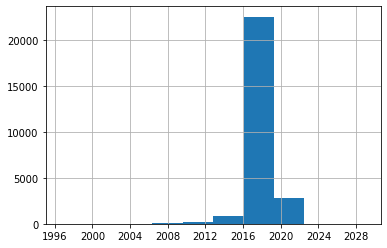

In [582]:
df_next_due.next_due_dt.hist()

In [589]:
df_next_due = df_snap[['client_code', 'policy_snapshot_as_on', 'next_due_dt']]
df_next_due['next_due_age'] = ((pd.to_datetime(df_snap.policy_snapshot_as_on, format='%Y%m%d') - df_snap.next_due_dt).dt.days/365)#, bins=[0,1,5,10,40], labels=['policy_age_1_yr', 'policy_age_5_yr', 'policy_age_10_yr', 'policy_age_40_yr'])


c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [594]:
df_next_due.next_due_age.max()

22.356164383561644

<AxesSubplot:>

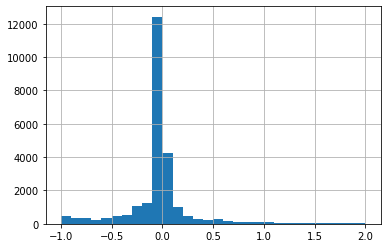

In [592]:
df_next_due.next_due_age.hist(bins=30, range=(-1,2))

In [598]:
df_next_due = df_snap[['client_code', 'policy_snapshot_as_on', 'next_due_dt']]
df_next_due['next_due_age'] = pd.cut(((pd.to_datetime(
    df_snap.policy_snapshot_as_on, format='%Y%m%d') - df_snap.next_due_dt).dt.days/365), 
                                     bins=[-100,-1,-0.2, 0, 0.2, 1, 100], 
                                     labels=['next_due_min_1_yr', 
                                             'next_due_min_0.2_yr', 
                                             'next_due_0_yr', 
                                             'next_due_0.2_yr', 
                                             'next_due_1_yr', 
                                             'next_due_100_yr'])

df_next_due = df_next_due.drop(columns=['policy_snapshot_as_on', 'next_due_dt'])
df_next_due['value'] = 1
df_pivot = df_next_due.pivot_table(values='value', 
                                       index='client_code', aggfunc='sum', 
                                       columns='next_due_age').fillna(0).astype(int)
df_pivot.divide(df_pivot.sum(axis=1), axis=0)

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


next_due_age,next_due_min_1_yr,next_due_min_0.2_yr,next_due_0_yr,next_due_0.2_yr,next_due_1_yr,next_due_100_yr
client_code,,,,,,
C100000,0.0,0.0,1.0,0.0,0.0,0.0
C100001,0.0,0.0,1.0,0.0,0.0,0.0
C100002,0.0,1.0,0.0,0.0,0.0,0.0
C100003,0.0,1.0,0.0,0.0,0.0,0.0
C100004,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
C154442,0.0,0.0,0.0,1.0,0.0,0.0
C154444,0.0,0.0,0.0,0.0,1.0,0.0
C154445,0.0,0.0,0.0,0.0,1.0,0.0


In [554]:
df_policy_age = df_snap[['client_code', 'policy_snapshot_as_on', 'commencement_dt']]

df_policy_age['policy_age'] = pd.cut(((pd.to_datetime(df_snap.policy_snapshot_as_on, format='%Y%m%d') - df_snap.commencement_dt).dt.days/365), bins=[0,1,5,10,40], labels=['policy_age_1_yr', 'policy_age_5_yr', 'policy_age_10_yr', 'policy_age_40_yr'])

df_policy_age = df_policy_age.drop(columns=['policy_snapshot_as_on', 'commencement_dt'])

df_policy_age['value'] = 1
df_pivot = df_policy_age.pivot_table(values='value', 
                                       index='client_code', aggfunc='sum', 
                                       columns='policy_age').fillna(0).astype(int)
df_pivot.divide(df_pivot.sum(axis=1), axis=0)

In [467]:
df_p

,client_code,policy_status,value
8,C107145,INFORCE,1
50,C120466,INFORCE,1
67,C101690,INFORCE,1
105,C115813,LAPSED,1
120,C116685,INFORCE,1
...,...,...,...
631399,C110790,INFORCE,1
631404,C117934,INFORCE,1
631408,C120592,INFORCE,1
631411,C111599,INFORCE,1


In [484]:
for col in pivot_cols:
    df_filt = df_snap[['client_code'] + [col]].copy()
    df_filt['value'] = 1
    df_pivot = df_filt.pivot_table(values='value', index='client_code', aggfunc='sum', columns=col).fillna(0).astype(int)
    print(df_pivot.divide(df_pivot.sum(axis=1), axis=0))

policy_payment_mode    H    M    Q    S    Y
client_code                                 
C100000              0.0  1.0  0.0  0.0  0.0
C100001              0.0  1.0  0.0  0.0  0.0
C100002              0.0  0.0  0.0  0.0  1.0
C100003              1.0  0.0  0.0  0.0  0.0
C100004              0.0  0.0  0.0  0.0  1.0
...                  ...  ...  ...  ...  ...
C154442              0.0  1.0  0.0  0.0  0.0
C154444              0.0  1.0  0.0  0.0  0.0
C154445              0.0  1.0  0.0  0.0  0.0
C154446              0.0  1.0  0.0  0.0  0.0
C154448              0.0  0.0  0.0  0.0  1.0

[22262 rows x 5 columns]
policy_status  INFORCE  LAPSED  TERMINATED
client_code                               
C100000            1.0     0.0         0.0
C100001            1.0     0.0         0.0
C100002            1.0     0.0         0.0
C100003            1.0     0.0         0.0
C100004            1.0     0.0         0.0
...                ...     ...         ...
C154442            1.0     0.0         0.0
C1

In [470]:
df_policy_pivot/df_policy_pivot.sum(axis=1)

,C100000,C100001,C100002,C100003,C100004,C100005,C100006,C100007,C100008,C100009,...,C154440,C154441,C154442,C154444,C154445,C154446,C154448,INFORCE,LAPSED,TERMINATED
client_code,,,,,,,,,,,,,,,,,,,,,
C100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C154442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C154444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C154445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [476]:
df_policy_pivot


policy_status,INFORCE,LAPSED,TERMINATED
client_code,,,
C100000,1,0,0
C100001,1,0,0
C100002,1,0,0
C100003,1,0,0
C100004,1,0,0
...,...,...,...
C154442,1,0,0
C154444,0,1,0
C154445,0,1,0


In [478]:
df_policy_pivot.divide(df_policy_pivot.sum(axis=1), axis=0)

1.0

In [448]:
df.policy_payment_mode

0         M
1         M
2         Y
3         Q
4         M
         ..
631417    M
631418    M
631419    M
631420    M
631421    M
Name: policy_payment_mode, Length: 600366, dtype: object

In [445]:
df.policy_term

0         20
1         15
2         20
3         15
4         15
          ..
631417    15
631418    18
631419    15
631420    20
631421    20
Name: policy_term, Length: 600366, dtype: int64

In [191]:
snap_date = 20181231

In [203]:
df_snap = df[(df.policy_snapshot_as_on == snap_date) & (df.policy_status == 'INFORCE')]

In [204]:
customer_specific_features = ['main_holder_gender', 'main_holder_dob',
                              'main_holder_smoker_flag', 'spouse_gender',
                               'spouse_dob', 'spouse_smoker_flag',
                               'child1_dob', 'child1_gender', 'child2_dob',
                               'child2_gender', 'child3_dob', 'child3_gender', 'child4_dob',
                               'child4_gender', 'child5_dob', 'child5_gender',
                               'main_holder_occupation', 
                               'client_code']

In [210]:
df_cust = df_snap[customer_specific_features]

dob_feat = ['main_holder_dob', 'spouse_dob', 'child1_dob', 'child2_dob',
       'child3_dob', 'child4_dob', 'child5_dob']

age_feat = []
for col in dob_feat:
    new_col = col[:-4] + '_age'
    df_cust[new_col] = pd.to_datetime(snap_date, format='%Y%m%d').year - df_cust[col].dt.year
    df_cust = df_cust.drop(columns=col)
    age_feat.append(new_col)

df_cust_numeric = df_cust.groupby('client_code')[age_feat].median()

df_cust_cat = df_cust.select_dtypes('object').groupby('client_code').first()

df_cust_fin = df_cust_cat.join(df_cust_numeric)

In [211]:
df_cust_fin

,main_holder_gender,main_holder_smoker_flag,spouse_gender,spouse_smoker_flag,child1_gender,child2_gender,child3_gender,child4_gender,child5_gender,main_holder_occupation,main_holder_age,spouse_age,child1_age,child2_age,child3_age,child4_age,child5_age
client_code,,,,,,,,,,,,,,,,,
C100000,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOUR & GRAIN MILL W,27.0,NaN,NaN,NaN,NaN,NaN,NaN
C100001,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHENA CULTIVATOR,37.0,NaN,NaN,NaN,NaN,NaN,NaN
C100002,M,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOUR & GRAIN MILL W,24.0,NaN,NaN,NaN,NaN,NaN,NaN
C100003,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MINISTER,27.0,NaN,NaN,NaN,NaN,NaN,NaN
C100004,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MINISTER,46.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C154407,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SALESMAN,39.0,NaN,NaN,NaN,NaN,NaN,NaN
C154416,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SALESMAN,30.0,NaN,NaN,NaN,NaN,NaN,NaN
C154436,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN


# Fill NA values

In [1000]:
def fillna_vals(df_cust):
    cat_cols = ['main_holder_gender', 'main_holder_smoker_flag', 'spouse_gender',
       'spouse_smoker_flag', 'child1_gender', 'child2_gender', 'child3_gender',
       'child4_gender', 'child5_gender', 'main_holder_occupation']

    df_cust[cat_cols] = df_cust[cat_cols].fillna('unk')

    zero_fill_cols = ['spouse_age', 'child1_age', 'child2_age',
           'child3_age', 'child4_age', 'child5_age']
    df_cust[zero_fill_cols] = df_cust[zero_fill_cols].fillna(0)
    
    return df_cust

# Categorical Encoding

In [1001]:
def cat_encoding(df_cust):
    cat_cols = ['main_holder_gender', 'main_holder_smoker_flag', 'spouse_gender',
           'spouse_smoker_flag', 'child1_gender', 'child2_gender', 'child3_gender',
           'child4_gender', 'child5_gender', 'main_holder_occupation']

    cat_enc = OrdinalEncoder(cols=cat_cols, verbose=False)

    cat_enc.fit(df_cust)

    df_cust = cat_enc.transform(df_cust)
    
    return df_cust

# Create Train Dataset

In [1051]:
def create_train_set_rec(df, snap_date, last_label_date):
    df_labels = create_labels(df, snap_date, last_label_date)

    df_cust = client_dataset(df, snap_date)

    df_cust = fillna_vals(df_cust)
    
    df_cust = cat_encoding(df_cust)
    df_cust = df_cust.drop(columns=['child4_age', 
                           'child5_age', 
                           'child5_gender', 
                           'child4_gender'])

    df_cross_sell = df_labels    

    return df_cust.join(df_cross_sell)

In [1003]:
def create_train_set(df, snap_date, last_label_date):
    df_labels = create_labels(df, snap_date, last_label_date)

    df_cust = client_dataset(df, snap_date)

    df_cust = fillna_vals(df_cust)
    
    df_cust = cat_encoding(df_cust)
    df_cust = df_cust.drop(columns=['child4_age', 
                           'child5_age', 
                           'child5_gender', 
                           'child4_gender'])

    df_cross_sell = (df_labels.sum(axis=1) > 0).astype(int)
    df_cross_sell.name = 'is_cross_sell'
    

    return df_cust.join(df_cross_sell)

In [1004]:
def create_pred_set(df, snap_date):
    df_cust = client_dataset(df, snap_date)

    df_cust = fillna_vals(df_cust)
    
    df_cust = cat_encoding(df_cust)
    df_cust = df_cust.drop(columns=['child4_age', 
                           'child5_age', 
                           'child5_gender', 
                           'child4_gender'])
    
    return df_cust

In [284]:
snap_date = 20181231
last_label_date = 20190630

In [285]:
df_labels = create_labels(df, snap_date, last_label_date)

df_cust = client_dataset(df, snap_date)

df_cust = fillna_vals(df_cust)

df_cross_sell = (df_labels.sum(axis=1) > 0).astype(int)
df_cross_sell.name = 'is_cross_sell'

df_train_test = df_cust.join(df_cross_sell)

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Cross sell prediction Model Training

## Train/test datasets

train/test selected so that there are no overlapping time regions

In [1005]:
policy_snaps = sorted(df.policy_snapshot_as_on.unique())

In [1034]:
df_train = pd.concat([create_train_set(df, policy_snaps[0], policy_snaps[6]),
                      create_train_set(df, policy_snaps[1], policy_snaps[7]),
                      create_train_set(df, policy_snaps[2], policy_snaps[8]),
                      create_train_set(df, policy_snaps[3], policy_snaps[9]),
                      create_train_set(df, policy_snaps[4], policy_snaps[10]),
                      create_train_set(df, policy_snaps[5], policy_snaps[11]),
                      create_train_set(df, policy_snaps[6], policy_snaps[12])
                     ])

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

client_code    26616
policy_age     26616
dtype: int64
client_code    27091
policy_age     27091
dtype: int64
client_code    27515
policy_age     27515
dtype: int64
client_code    28032
policy_age     28032
dtype: int64
client_code    28501
policy_age     28501
dtype: int64
client_code    29169
policy_age     29169
dtype: int64
client_code    29841
policy_age     29841
dtype: int64


In [1035]:
df_train.columns

Index(['main_holder_gender', 'main_holder_smoker_flag', 'spouse_gender',
       'spouse_smoker_flag', 'child1_gender', 'child2_gender', 'child3_gender',
       'main_holder_occupation', 'main_holder_age', 'spouse_age', 'child1_age',
       'child2_age', 'child3_age', 'H', 'M', 'Q', 'S', 'Y', 'INFORCE',
       'LAPSED', 'TERMINATED', 'CASH', 'CHEQUE', 'INFORCED_AGENT',
       'SUSPENDED_AGENT', 'TERMINATED_AGENT', 'Female', 'Male',
       'policy_age_1_yr', 'policy_age_5_yr', 'policy_age_10_yr',
       'policy_age_40_yr', 'next_due_min_1_yr', 'next_due_min_0.2_yr',
       'next_due_0_yr', 'next_due_0.2_yr', 'next_due_1_yr', 'next_due_100_yr',
       'rider_count', 'rider_prem', 'rider_sum_assured', 'premium_value',
       'total_sum_assuared', 'monthly_premium', 'is_cross_sell'],
      dtype='object')

In [1036]:
df_train.is_cross_sell.value_counts(dropna=False)

0    159246
1      4259
Name: is_cross_sell, dtype: int64

In [1037]:
df_test = create_train_set(df, policy_snaps[12], policy_snaps[18])

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


client_code    33490
policy_age     33490
dtype: int64


c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1038]:
train_X = df_train.drop(columns='is_cross_sell')
train_y = df_train['is_cross_sell']

test_X = df_test.drop(columns='is_cross_sell')
test_y = df_test['is_cross_sell']

## Model Training

In [1039]:
model = LGBMClassifier(learning_rate=0.1, max_depth=6, min_child_samples=1000, n_estimators=300, num_leaves=3, random_state=2, class_weight='balanced')
model.fit(train_X, train_y)

pred_y = model.predict(test_X)
pred_y_prob = model.predict_proba(test_X)[:,1]

pred_y_train = model.predict(train_X)
pred_y_train_prob = model.predict_proba(train_X)[:,1]

## Model Evaluation

In [1040]:
print(confusion_matrix(test_y, pred_y))

[[20944  5902]
 [  211   356]]


In [1041]:
print(classification_report(train_y, pred_y_train))

              precision    recall  f1-score   support

           0       0.99      0.80      0.89    159246
           1       0.09      0.70      0.15      4259

    accuracy                           0.80    163505
   macro avg       0.54      0.75      0.52    163505
weighted avg       0.97      0.80      0.87    163505



In [1042]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87     26846
           1       0.06      0.63      0.10       567

    accuracy                           0.78     27413
   macro avg       0.52      0.70      0.49     27413
weighted avg       0.97      0.78      0.86     27413



In [1043]:
print(roc_auc_score(train_y, pred_y_train_prob))

0.8497478197303218


In [1044]:
print(roc_auc_score(test_y, pred_y_prob))

0.796146280023456


# Recommendation prediction model training

In [1045]:
policy_snaps = sorted(df.policy_snapshot_as_on.unique())

In [1130]:
df_train = pd.concat([create_train_set_rec(df, policy_snaps[0], policy_snaps[6]),
                      create_train_set_rec(df, policy_snaps[1], policy_snaps[7]),
                      create_train_set_rec(df, policy_snaps[2], policy_snaps[8]),
                      create_train_set_rec(df, policy_snaps[3], policy_snaps[9]),
                      create_train_set_rec(df, policy_snaps[4], policy_snaps[10]),
                      create_train_set_rec(df, policy_snaps[5], policy_snaps[11]),
                      create_train_set_rec(df, policy_snaps[6], policy_snaps[12])
                     ])

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

client_code    26616
policy_age     26616
dtype: int64
client_code    27091
policy_age     27091
dtype: int64
client_code    27515
policy_age     27515
dtype: int64
client_code    28032
policy_age     28032
dtype: int64
client_code    28501
policy_age     28501
dtype: int64
client_code    29169
policy_age     29169
dtype: int64
client_code    29841
policy_age     29841
dtype: int64


In [1131]:
df_train.columns

Index(['main_holder_gender', 'main_holder_smoker_flag', 'spouse_gender',
       'spouse_smoker_flag', 'child1_gender', 'child2_gender', 'child3_gender',
       'main_holder_occupation', 'main_holder_age', 'spouse_age', 'child1_age',
       'child2_age', 'child3_age', 'H', 'M', 'Q', 'S', 'Y', 'INFORCE',
       'LAPSED', 'TERMINATED', 'CASH', 'CHEQUE', 'INFORCED_AGENT',
       'SUSPENDED_AGENT', 'TERMINATED_AGENT', 'Female', 'Male',
       'policy_age_1_yr', 'policy_age_5_yr', 'policy_age_10_yr',
       'policy_age_40_yr', 'next_due_min_1_yr', 'next_due_min_0.2_yr',
       'next_due_0_yr', 'next_due_0.2_yr', 'next_due_1_yr', 'next_due_100_yr',
       'rider_count', 'rider_prem', 'rider_sum_assured', 'premium_value',
       'total_sum_assuared', 'monthly_premium', 'EDUCATION', 'HEALTH',
       'INVESTMENT', 'PROTECTION', 'RETIREMENT'],
      dtype='object')

In [1132]:
df_test = create_train_set_rec(df, policy_snaps[12], policy_snaps[18])

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


client_code    33490
policy_age     33490
dtype: int64


c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1133]:
label_cols = ['EDUCATION', 'HEALTH',
       'INVESTMENT', 'PROTECTION', 'RETIREMENT']

In [1134]:
train_X = df_train.drop(columns=label_cols)
train_y = df_train[label_cols]

test_X = df_test.drop(columns=label_cols)
test_y = df_test[label_cols]

## Model Training

In [1135]:
model_rec = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced')
# model = LGBMClassifier(learning_rate=0.1, max_depth=6, min_child_samples=1000, n_estimators=300, num_leaves=3, random_state=2, class_weight='balanced')
model_rec.fit(train_X, train_y)

pred_y = model_rec.predict(test_X)
pred_y_prob = model_rec.predict_proba(test_X)

pred_y_train = model_rec.predict(train_X)
pred_y_train_prob = model_rec.predict_proba(train_X)

## Model Evaluation

In [1136]:
pred_class = pd.DataFrame(pred_y_prob[0][:,1])
pred_class['HEALTH'] = pred_y_prob[1][:,1]
pred_class['INVESTMENT'] = pred_y_prob[2][:,1]
pred_class['PROTECTION'] = pred_y_prob[3][:,1]
pred_class['RETIREMENT'] = pred_y_prob[4][:,1]

In [1137]:
pred_class.columns = ['EDUCATION', 'HEALTH', 'INVESTMENT', 'PROTECTION', 'RETIREMENT']

In [1138]:
pred_class

,EDUCATION,HEALTH,INVESTMENT,PROTECTION,RETIREMENT
0,0.056909,0.235426,0.216432,0.002034,0.089868
1,0.032200,0.207885,0.178971,0.001970,0.088257
2,0.023886,0.397527,0.228580,0.024635,0.217437
3,0.021387,0.266877,0.437143,0.012756,0.202285
4,0.017716,0.287291,0.406415,0.020229,0.226465
...,...,...,...,...,...
27408,0.082060,0.316706,0.260323,0.002426,0.104207
27409,0.050943,0.281560,0.173310,0.008082,0.192402
27410,0.059480,0.229513,0.174828,0.010439,0.074415
27411,0.048483,0.267479,0.173610,0.009736,0.142501


In [1139]:
accuracy_score(test_y, pred_y)

0.9691022507569401

# Submission set

In [968]:
df_sub = create_pred_set(df, policy_snaps[18])

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [969]:
df_sub = df_pred.join(df_sub, how='inner')

In [970]:
pred_sub = model.predict_proba(df_sub)[:,1]

In [971]:
df_sub['probability_of_cross_sell'] = pred_sub

In [972]:
df_sub = df_sub[['probability_of_cross_sell']]

In [974]:
df_sub.index.name = 'map_client_cd'

In [975]:
df_sub

,probability_of_cross_sell
map_client_cd,
C100003,0.596445
C100004,0.679340
C100009,0.531178
C100014,0.015594
C100015,0.533946
...,...
C154448,0.432619
C154449,0.422577
C154450,0.521595


In [1143]:
sub_y_prob_rec = model_rec.predict_proba(df_sub_rec)

In [1144]:
pred_class = pd.DataFrame(sub_y_prob_rec[0][:,1])
pred_class['HEALTH'] = sub_y_prob_rec[1][:,1]
pred_class['INVESTMENT'] = sub_y_prob_rec[2][:,1]
pred_class['PROTECTION'] = sub_y_prob_rec[3][:,1]
pred_class['RETIREMENT'] = sub_y_prob_rec[4][:,1]

In [1145]:
pred_class.columns = ['EDUCATION', 'HEALTH', 'INVESTMENT', 'PROTECTION', 'RETIREMENT']

In [1147]:
df_sub_rec = pred_class.idxmax(axis=1)

In [1148]:
df_sub_rec

0            HEALTH
1            HEALTH
2            HEALTH
3        INVESTMENT
4        INVESTMENT
            ...    
28979        HEALTH
28980    INVESTMENT
28981    INVESTMENT
28982    PROTECTION
28983    PROTECTION
Length: 28984, dtype: object

# Model Explanations

In [864]:
pd.Series(model.feature_importances_, index=train_X.columns).sort_values(ascending=False)

premium_value              285
main_holder_age            283
monthly_premium            275
rider_prem                 261
total_sum_assuared         261
main_holder_occupation     256
rider_sum_assured          241
next_due_100_yr             94
LAPSED                      94
spouse_age                  88
INFORCE                     75
policy_age_1_yr             65
child1_age                  47
rider_count                 46
child2_age                  39
Female                      39
next_due_1_yr               38
policy_age_10_yr            37
main_holder_gender          35
next_due_0.2_yr             35
SUSPENDED_AGENT             30
policy_age_5_yr             28
Q                           27
INFORCED_AGENT              27
child1_gender               26
M                           26
policy_age_40_yr            26
next_due_min_0.2_yr         22
spouse_gender               21
S                           19
TERMINATED_AGENT            18
main_holder_smoker_flag     17
child2_g